In [1]:
import numpy as np
import matplotlib.pyplot as  plt
from numpy.polynomial.legendre import leggrid2d

### Legendre Polynomial

In [2]:
x = y = np.linspace(1,800,800)
xx, yy = np.meshgrid(x, y)
coeff = [[0,1],[0,0]]
coeff2 = [[0,0],[1,0]]
coeffs = [[[0,1],[0,0]], [[0,0],[1,0]], [[0,0],[0,1]]]

In [3]:
H10 = leggrid2d((x-400)/800, (y-400)/800, coeff)
H01 = leggrid2d((x-400)/800, (y-400)/800, coeff2)

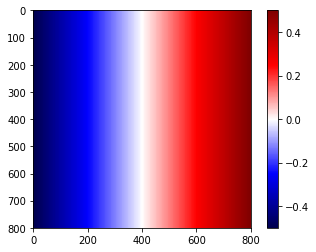

In [4]:
im=plt.imshow(H10, cmap='seismic')
plt.colorbar(im)

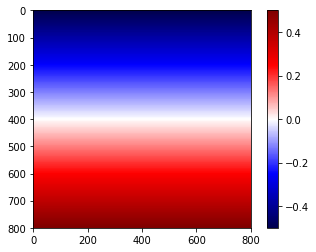

In [5]:
im=plt.imshow(H01, cmap='seismic')
plt.colorbar(im)

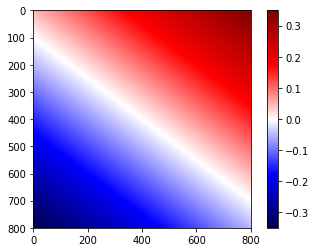

In [6]:
im=plt.imshow(0.3*H10 - 0.4*H01, cmap='seismic')
plt.colorbar(im)

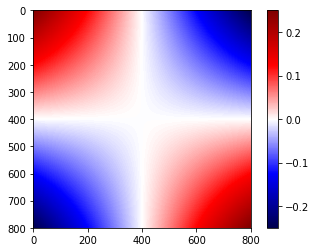

In [8]:
H11 = leggrid2d((x-400)/800, (y-400)/800, [[0,0],[0,1]])
im=plt.imshow(H11, cmap='seismic')
plt.colorbar(im)

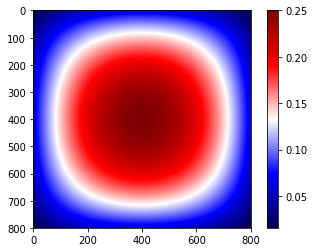

In [9]:
H22 = leggrid2d((x-400)/800, (y-400)/800, [[0,0,0],[0,0,0],[0,0,1]])
im=plt.imshow(H22, cmap='seismic')
plt.colorbar(im)

### Airy Disk

In [1]:
from astropy.modeling.functional_models import AiryDisk2D
from utils import *
from modeling import *

%load_ext autoreload
%autoreload 2

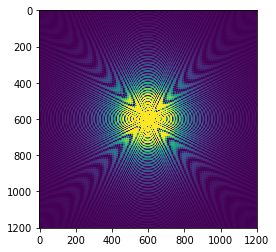

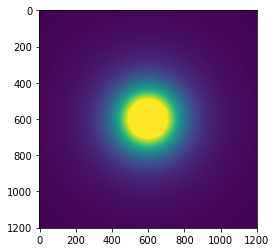

In [2]:
size = 1201
x = np.linspace(1,size,size)
y = np.linspace(1,size,size)
xx, yy = np.meshgrid(x, y)

cen = ((size-1)/2., (size-1)/2.)
Airy = AiryDisk2D(amplitude=1, x_0=cen[0], y_0=cen[1], radius=5)
A = Airy(xx, yy)
A  = A/ A.sum() * 100
plt.imshow(A, norm=norm0, vmax=1e-5)
plt.show()

P = power2d(xx, yy, 3, 5, 0.1, cen)
plt.imshow(P, norm=norm0, vmax=1e-5)
plt.show()

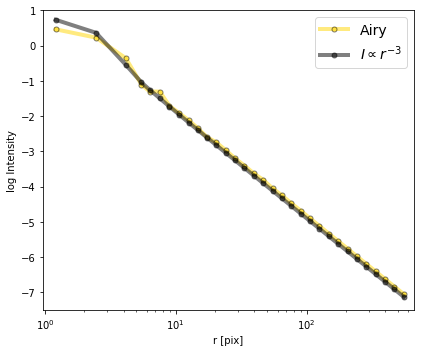

In [3]:
plt.figure(figsize=(6,5))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(A, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2., lw=4, pixel_scale=2.5,
                                              xunit="pix", yunit="Intensity",
                                              color="gold", label='Airy', alpha=0.5, 
                                              scatter=False, core_undersample=False)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(P, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2., lw=4, pixel_scale=2.5,
                                              xunit="pix", yunit="Intensity",
                                              color="k", label='$I \propto r^{-3}$', alpha=0.5, 
                                              scatter=False, core_undersample=False)
plt.ylim(-7.5,1)
plt.legend(fontsize=14)
plt.tight_layout()

In [5]:
# PSF Parameters
image_size = size
pixel_scale = 2.5
beta = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                     # moffat fwhm, in arcsec

n0 = 3.28                    # estimated true power index
theta_0 = 5.                # radius at which power law is flattened, in arcsec (arbitrary)

n_s = np.array([n0, 2.28, 1.32, 4])                   # power index
theta_s = np.array([theta_0, 10**1.87, 10**2.18, 1200])      # transition radius in arcsec

# Multi-power PSF
frac = 0.3

params_mpow = {"fwhm":fwhm, "beta":beta, "frac":frac, "n_s":n_s, 'theta_s':theta_s}
psf = PSF_Model(params=params_mpow, aureole_model='multi-power')

# Build grid of image for drawing
psf.make_grid(image_size, pixel_scale=pixel_scale)

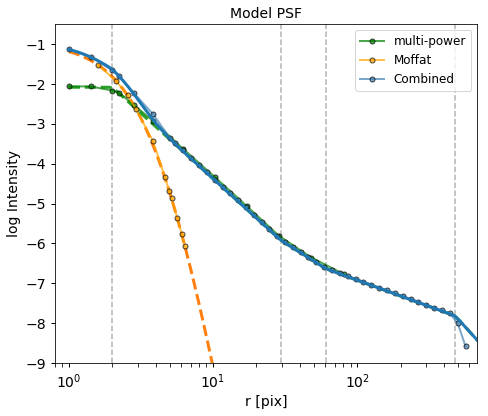

In [6]:
# Generate core and aureole PSF
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e7, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e

# Galsim 2D model averaged in 1D
psf.plot_model_galsim()

# 2D DF PSF
PSF_DF = psf.draw_aureole2D_in_real([cen], Flux=np.array([100]))[0]
D = PSF_DF(xx,yy)/PSF_DF(xx,yy).sum() * 100

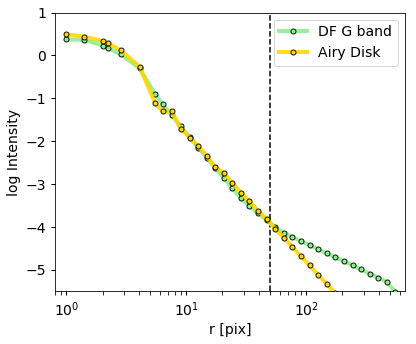

In [7]:
plt.figure(figsize=(6,5))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(D, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="pix", yunit="Intensity",
                                              color="lightgreen", label='DF G band', alpha=0.9, 
                                              scatter=False, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(A, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="pix", yunit="Intensity",
                                              color="gold", label='Airy Disk', alpha=0.9, 
                                              scatter=False, core_undersample=True)
plt.axvline(50, color='k', ls='--')
plt.legend()
plt.ylim(-5.5,1)
plt.tight_layout()

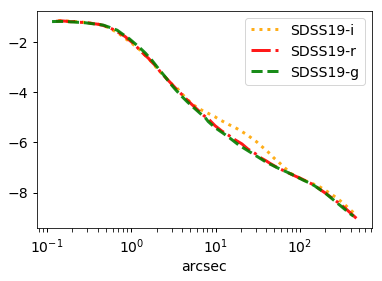

In [18]:
import pandas as pd
PSF_SDSS19 = pd.read_csv("./web_digit/SDSS2019.csv", skiprows=1)
labels_SDSS = ["SDSS19-i", "SDSS19-r", "SDSS19-g"]
for k, (lab,c,ls) in enumerate(zip(labels_SDSS,['orange','r','g'],[':','-.','--'])):
    xsdss, ysdss = PSF_SDSS19.iloc[:,k*2], ((PSF_SDSS19.iloc[:,k*2+1])/(-2.5)+math.log10(0.4**2))
    y_sort = ysdss.reindex(np.argsort(xsdss))
    x_sort = xsdss.reindex(np.argsort(xsdss))
    plt.semilogx(x_sort, y_sort, color=c, lw=3, ls=ls, alpha=0.9, label=lab)
    
plt.xlabel('arcsec')
plt.legend()

In [25]:
from scipy.integrate import simps
I_tot = simps(10**y_sort[~np.isnan(y_sort)], x_sort[~np.isnan(y_sort)])
I_tot

0.03986154290829599

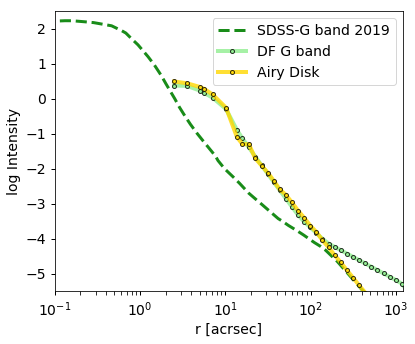

In [29]:
plt.figure(figsize=(6,5))

plt.semilogx(x_sort, y_sort+np.log10(100/I_tot), color=c, lw=3, ls=ls, alpha=0.9, label='SDSS-G band 2019')
    
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(D, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="arcsec", yunit="Intensity",
                                              color="lightgreen", label='DF G band', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(A, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="arcsec", yunit="Intensity",
                                              color="gold", label='Airy Disk', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)

plt.legend()
plt.ylim(-5.5, 2.5)
plt.xlim(0.1, 1.2e3)

plt.tight_layout()

In [37]:
psf_model_sdss = fits.getdata('./real/Stacked_PSF_SDSS.fits')
image_psf_sdss = galsim.ImageF(psf_model_sdss)

k_scale = 6
pixel_scale_sdss = pixel_scale / k_scale

psf_sdss = galsim.InterpolatedImage(image_psf_sdss, flux=100*k_scale**2, scale=pixel_scale_sdss)
image_sdss = psf_sdss.drawImage(nx=1201, ny=1201, scale=pixel_scale_sdss).array
cen_sdss = (image_sdss.shape[1]-0.5)//2, (image_sdss.shape[0]-0.5)//2

psf_sdss2 = galsim.InterpolatedImage(image_psf_sdss, flux=100, scale=pixel_scale_sdss)
image_sdss2 = psf_sdss2.drawImage(nx=301, ny=301, scale=pixel_scale).array

cen_sdss2 = (image_sdss2.shape[1]-0.5)//2, (image_sdss2.shape[0]-0.5)//2

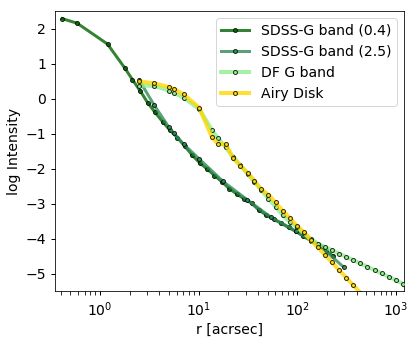

In [41]:
plt.figure(figsize=(6,5))

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(image_sdss, cen=cen_sdss, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=3, pixel_scale=pixel_scale_sdss, seeing=0.4,
                                              xunit="arcsec", yunit="Intensity", mock=True,
                                              color="darkgreen", label='SDSS-G band (0.4)', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(image_sdss2, cen=cen_sdss2, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=3, pixel_scale=pixel_scale, 
                                              xunit="arcsec", yunit="Intensity", mock=True,
                                              color="seagreen", label='SDSS-G band (2.5)', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)
    
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(D, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="arcsec", yunit="Intensity",
                                              color="lightgreen", label='DF G band', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(A, cen=cen, 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=2, lw=4, pixel_scale=2.5,
                                              xunit="arcsec", yunit="Intensity",
                                              color="gold", label='Airy Disk', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)

plt.legend()
plt.ylim(-5.5, 2.5)
plt.xlim(0.35, 1.2e3)

plt.tight_layout()